数据描述: https://github.com/Bowen999/SLAM/blob/main/datasets/README.md  
test_set(目前不考虑test_set2）：用于测试forward model和reverse model  

Forward: Structure --> MS2  
Reverse: MS2 --> Structure  

# Package needed

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from rdkit.Chem import SDWriter

import numpy as np
import ms_entropy as me
import matplotlib.pyplot as plt
import numpy as np

import numpy as np
import ms_entropy as me
import matplotlib.pyplot as plt
import numpy as np
import spectral_entropy # How to download: https://github.com/YuanyueLi/SpectralEntropy/blob/master/example.ipynb, 
                        # after generate spectral_entropy folder, need to move it to the correct path

# 1 Forward

### 1.1 Input  
Input structure have more than one format, including **SMILES, InChIKey, .sdf file**...  
But they can be coverted to (almost) any other format using RDKit

#### smiles to sdf

In [2]:
def smiles_to_sdf(smiles: str, output_sdf_path: str):
    """
    Converts a SMILES string to an SDF file.

    Args:
        smiles (str): The SMILES string of the molecule.
        output_sdf_path (str): The path where the output SDF file will be saved.
    """
    # Convert SMILES to molecule
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError("Invalid SMILES string provided.")

    # Add hydrogens
    mol = Chem.AddHs(mol)

    # Generate 3D coordinates
    AllChem.EmbedMolecule(mol, AllChem.ETKDG())

    # Write molecule to SDF
    writer = Chem.SDWriter(output_sdf_path)
    writer.write(mol)
    writer.close()

    print(f"SDF file successfully written to: {output_sdf_path}")

In [3]:
smiles_to_sdf('CN1CC(=O)N=C1N', 'output.sdf')

SDF file successfully written to: output.sdf


#### sdf to smiles

In [4]:
def sdf_to_smiles(input_sdf_path: str):
    """
    Reads the first valid molecule from an SDF file and returns its SMILES string.

    Args:
        input_sdf_path (str): The path to the input SDF file.

    Returns:
        str: The SMILES string of the first valid molecule.
    """
    supplier = Chem.SDMolSupplier(input_sdf_path)
    
    for mol in supplier:
        if mol is not None:
            smiles = Chem.MolToSmiles(mol)
            return smiles

    raise ValueError("No valid molecules found in the SDF file.")

In [5]:
smiles = sdf_to_smiles('input.sdf')
print(smiles)

CN1CC(=O)N=C1N


### 1.2 Output
* Some scores can be used for comparing MS2 similarity, in there, we use:
* Unweighted entropy similarity
* Entropy similarity
* Dot product

In [6]:
peaks_query = [[400, 100]]
peaks_reference =[[100, 82],[200, 50],[300, 80],[400, 100], [500, 10], [600, 10], [700, 10], [60, 10]]

peaks_query = np.array(peaks_query, dtype=np.float32)
peaks_reference = np.array(peaks_reference, dtype=np.float32)

In [7]:
# Calculate unweighted entropy similarity.
unweighted_similarity = me.calculate_unweighted_entropy_similarity(peaks_query, peaks_reference, ms2_tolerance_in_da = 0.05)
print(f"Unweighted entropy similarity: {unweighted_similarity}.")

# Calculate entropy similarity.
similarity = me.calculate_entropy_similarity(peaks_query, peaks_reference, ms2_tolerance_in_da = 0.05)
print(f"Entropy similarity: {similarity}.")

# Dot product
similarity = spectral_entropy.similarity(peaks_query, peaks_reference, method="dot_product", ms2_da=0.05)
print("dot_product: {}.".format(similarity))
similarity = spectral_entropy.similarity(peaks_query, peaks_reference, method="weighted_dot_product", ms2_da=0.05)
print("weighted_dot_product: {}.".format(similarity))

Unweighted entropy similarity: 0.4895104169845581.
Entropy similarity: 0.4374931752681732.
dot_product: 0.6198876217728473.
weighted_dot_product: 0.5054086081198067.


#### Plot (if you want, but not necessary)

/var/folders/q1/mfxy01nj293b7bbnnhjkt_6w0000gn/T/ipykernel_49988/1455150799.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(new_yticks)  # Set the new y-tick labels


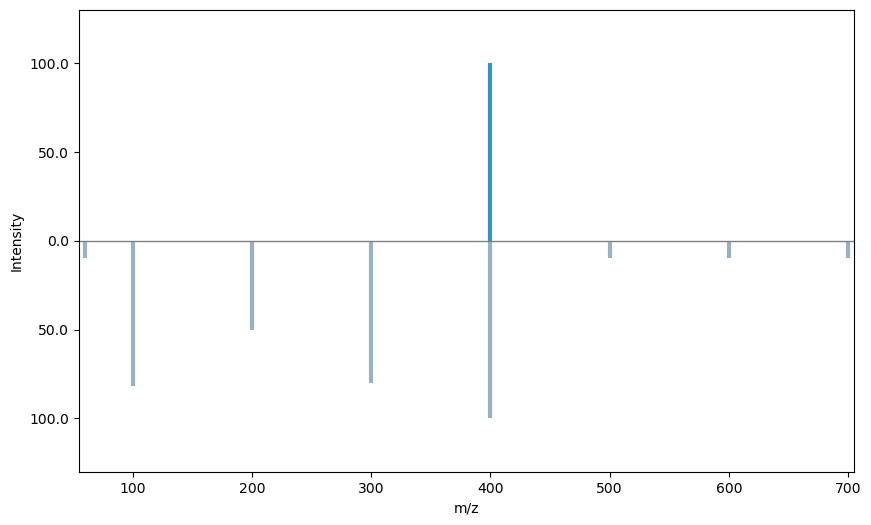

In [8]:
### Line size 
num_peaks = max(len(peaks_query), len(peaks_reference))
line_size = (10 / num_peaks) * 6
line_size = max(1.7, min(3, line_size))


### Determine the x and y ranges
x_min = min(peaks_query[:, 0].min(), peaks_reference[:, 0].min())
x_max = max(peaks_query[:, 0].max(), peaks_reference[:, 0].max())

y_max_query = peaks_query[:, 1].max()
y_max_reference = peaks_reference[:, 1].max()

y_min = -max(y_max_query, y_max_reference) * 1.3
y_max = max(y_max_query, y_max_reference) * 1.3




#### Plotting with specified stem size and annotations
plt.figure(figsize=(10, 6))
query_stem = plt.stem(peaks_query[:, 0], peaks_query[:, 1], linefmt='#3795BD', basefmt=" ", label='Query', markerfmt=' ')
reference_stem = plt.stem(peaks_reference[:, 0], -peaks_reference[:, 1], linefmt='#9BB0C1', basefmt=" ", label='Reference', markerfmt=' ')

# Add labels and title
plt.xlabel("m/z")
plt.ylabel("Intensity")

# Apply the x and y ranges
plt.ylim([y_min, y_max])
plt.xlim([x_min - 5, x_max + 5])

plt.axhline(0, color='gray', lw=1)

# Set stem size to 2
plt.setp(query_stem, linewidth=line_size)
plt.setp(reference_stem, linewidth=line_size)

yticks = plt.gca().get_yticks()  # Get current y-tick values
new_yticks = [abs(tick) if tick < 0 else tick for tick in yticks]  # Make negative ticks positive
plt.gca().set_yticklabels(new_yticks)  # Set the new y-tick labels


threshold_query = 0.8 * peaks_query[:, 1].max()
threshold_reference = 0.8 * peaks_reference[:, 1].max()


# Show the plot
plt.grid(False)
plt.show()

# 2 Reverse

### 2.1 Input

In [ ]:
peaks_query = [[400, 100]]
peaks_reference =[[100, 82],[200, 50],[300, 80],[400, 100], [500, 10], [600, 10], [700, 10], [60, 10]]

peaks_query = np.array(peaks_query, dtype=np.float32)
peaks_reference = np.array(peaks_reference, dtype=np.float32)

### 2.2 Output
For output lipid structure, we have two way to compare:
* 1: compare SMILES directly, by calculating **tanimoto similarity**
* 2: convert to InChIKey, see if the first block are 100% same

#### tanimoto similarity

In [ ]:
def smiles_tanimoto(smiles1: str, smiles2: str) -> float:
    """
    Calculates the Tanimoto similarity between two SMILES strings.

    Args:
        smiles1 (str): The first SMILES string.
        smiles2 (str): The second SMILES string.

    Returns:
        float: Tanimoto similarity score between 0 and 1.
    """
    # Convert SMILES to molecules
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)

    if mol1 is None or mol2 is None:
        raise ValueError("Invalid SMILES string provided.")

    # Generate fingerprints
    fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, radius=2, nBits=2048)
    fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, radius=2, nBits=2048)

    # Calculate Tanimoto similarity
    similarity = DataStructs.TanimotoSimilarity(fp1, fp2)

    return similarity

In [ ]:
sim = smiles_tanimoto('CN(CC(=O)O)C(=N)N', 'CN1CC(=O)N=C1N')
print(sim)

#### InChIkey

In [ ]:
# SMILES to InChI Key first Block

def get_inchikey_first_block(smiles):
    """Get the first block of InChIKey from a SMILES string."""
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        inchikey = Chem.inchi.MolToInchiKey(mol)
        first_block = inchikey.split('-')[0]
        return first_block
    else:
        return None

In [ ]:
first_block = get_inchikey_first_block('CN1CC(=O)N=C1N')
print(first_block)

In [29]:
def compare_strings(s1: str, s2: str) -> str:
    """
    Compares two strings of 14 characters.
    
    Args:
        s1 (str): First string.
        s2 (str): Second string.

    Returns:
        str: 'y' if they are exactly the same and 14 characters long, otherwise 'n'.
    """
    if len(s1) == 14 and len(s2) == 14:
        if s1 == s2:
            return 'Y'
        else:
            return 'N'
    else:
        return 'Not Avaiable, please check the input value'

In [32]:
compare_strings('DDRJAANPRJIHGJ', 'CVSVTCORWBXHQV')

'N'

/var/folders/q1/mfxy01nj293b7bbnnhjkt_6w0000gn/T/ipykernel_49245/2608430183.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(new_yticks)  # Set the new y-tick labels


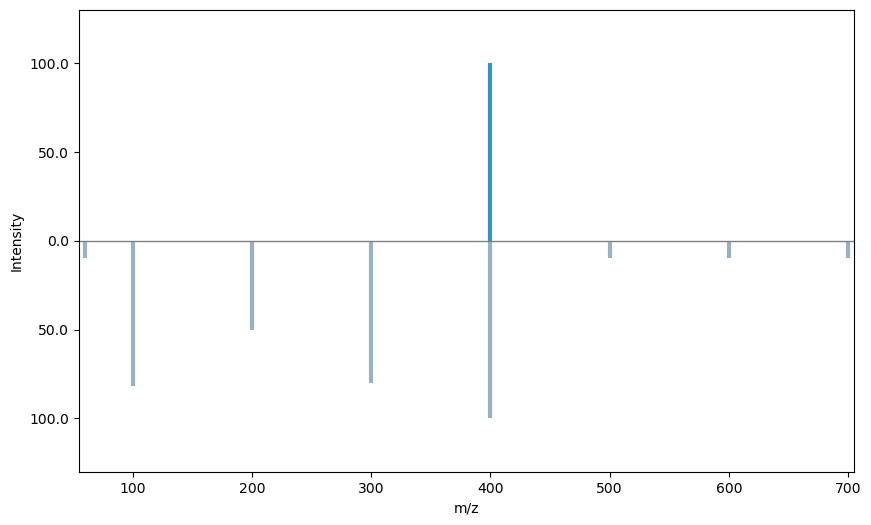